##**🐝 Bee Detection with YOLOv12 (Drone vs Worker)**
**Goal:** Train and evaluate a YOLOv12 model to detect two bee classes — **Drone** and **Worker** — with clean splits (train/val/test) and clear metrics (mAP, precision/recall, confusion matrix).

**Key points**
- Classes: `0 = Drone`, `1 = Worker`
- Dataset: Roboflow export (train/valid/test)

**Augmentations**
- Grayscale (subset of images) → learn texture/shape beyond color
- Noise (small % of pixels) → tolerate camera artifacts / compression

## Environment setup

### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [1]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 91.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 120.2 MB/s eta 0:00:00


In [2]:
import cv2
import os
from ultralytics import YOLO
import supervision as sv
from roboflow import Roboflow
from pathlib import Path
from IPython.display import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


## Download dataset from Roboflow Universe

In [3]:

rf = Roboflow(api_key="Enter your API")
project = rf.workspace("plan-lzmi4").project("my-first-project-qsn5k")
version = project.version(6)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to My-First-Project-6 in yolov12:: 100%|██████████| 152/152 [00:00<00:00, 1697.48it/s]


In [4]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [5]:
!nvidia-smi

Thu Nov 13 17:16:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
base = Path("/content/My-First-Project-6")

print("IMAGE COUNTS BEFORE FILTERING:")
for split in ["train", "valid", "test"]:
    img_dir = base / split / "images"
    num_images = len(list(img_dir.glob("*.jpg"))) + len(list(img_dir.glob("*.png")))
    print(f"  {split}: {num_images} images")

IMAGE COUNTS BEFORE FILTERING:
  train: 60 images
  valid: 5 images
  test: 5 images


In [7]:
# Get to know the ratio in our dataset
worker_count = 0
drone_count  = 0
worker_idx = 1
drone_idx = 0
for split in ["train", "valid"]:
    lbl_dir = base / split / "labels"
    for lbl_file in lbl_dir.glob("*.txt"):
        with open(lbl_file, "r") as f:
            labels = [line.strip().split()[0] for line in f if line.strip()]
        cls_ids = [int(idx) for idx in labels]
        worker_count += cls_ids.count(worker_idx) if worker_idx is not None else 0
        drone_count  += cls_ids.count(drone_idx)  if drone_idx is not None else 0
print(f"🐝 Worker:Drone ratio = {worker_count/drone_count:.2f}:1")

🐝 Worker:Drone ratio = 34.30:1


## Fine-tune YOLOv12 model

In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12n.pt`, but we can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on preference.

In [8]:
model = YOLO('yolov12n.pt')

results = model.train(data=f'{dataset.location}/data.yaml',
    epochs=50,
    imgsz=640,
    batch=8,
    project="/content/yolo12_runs_version6",
    name="bee_imbalance",
    exist_ok=True,
    cache=True,
    lr0=0.005,
    warmup_epochs=3,
    patience=7,
)

100%|██████████| 5.26M/5.26M [00:00<00:00, 94.9MB/s]


New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12n.pt, data=/content/My-First-Project-6/data.yaml, epochs=50, time=None, patience=7, batch=8, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=/content/yolo12_runs_version6, name=bee_imbalance, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fa

100%|██████████| 755k/755k [00:00<00:00, 23.0MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      2368  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2, 1, 2]          
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2, 1, 4]          
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    174720  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytics

train: Scanning /content/My-First-Project-6/train/labels... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<00:00, 1940.46it/s]

train: New cache created: /content/My-First-Project-6/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.1GB RAM): 100%|██████████| 60/60 [00:00<00:00, 326.25it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/My-First-Project-6/valid/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 23045.63it/s]

val: New cache created: /content/My-First-Project-6/valid/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 5/5 [00:00<00:00, 115.02it/s]


Plotting labels to /content/yolo12_runs_version6/bee_imbalance/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/yolo12_runs_version6/bee_imbalance
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.61G      1.917      3.592      1.757        257        640: 100%|██████████| 8/8 [00:23<00:00,  2.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.32s/it]

                   all          5        206     0.0396       0.41     0.0906     0.0347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.71G      1.572      3.395      1.481        228        640: 100%|██████████| 8/8 [00:01<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.91it/s]

                   all          5        206     0.0539      0.319      0.105     0.0504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.54G       1.52      3.051      1.352        154        640: 100%|██████████| 8/8 [00:02<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]

                   all          5        206     0.0796      0.522      0.202      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.16G      1.485       2.83      1.318        208        640: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.71it/s]

                   all          5        206      0.083      0.734      0.294      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.59G      1.641      2.823       1.32        278        640: 100%|██████████| 8/8 [00:01<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]

                   all          5        206      0.087      0.724      0.308      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.21G      1.566      2.497      1.276        268        640: 100%|██████████| 8/8 [00:01<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.97it/s]

                   all          5        206      0.106      0.937      0.411      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.47G       1.59      2.336      1.324         66        640: 100%|██████████| 8/8 [00:01<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.69it/s]

                   all          5        206      0.913      0.297      0.403      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.21G      1.509      1.986      1.277        150        640: 100%|██████████| 8/8 [00:01<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.01it/s]

                   all          5        206      0.977      0.277      0.455      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       2.4G      1.531      1.806      1.301        109        640: 100%|██████████| 8/8 [00:01<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.33it/s]

                   all          5        206      0.953      0.315       0.51      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.37G      1.493        1.6      1.306        232        640: 100%|██████████| 8/8 [00:02<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all          5        206      0.939      0.363      0.512      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.99G      1.519      1.559      1.285        220        640: 100%|██████████| 8/8 [00:01<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.83it/s]

                   all          5        206      0.924      0.412      0.507      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.29G      1.443      1.352      1.291        135        640: 100%|██████████| 8/8 [00:01<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]

                   all          5        206      0.932      0.401      0.499      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.03G      1.453      1.348      1.282        150        640: 100%|██████████| 8/8 [00:01<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.73it/s]

                   all          5        206      0.846      0.444      0.532      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.89G      1.474      1.402      1.328        241        640: 100%|██████████| 8/8 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.29it/s]

                   all          5        206      0.524      0.494      0.606      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.47G      1.486      1.378      1.324        380        640: 100%|██████████| 8/8 [00:02<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.74it/s]

                   all          5        206      0.572       0.51      0.576      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.53G      1.359      1.324      1.293         85        640: 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]

                   all          5        206      0.555      0.545      0.577      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.78G      1.376      1.194      1.289        233        640: 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]

                   all          5        206      0.534      0.583      0.591      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.64G      1.338      1.143      1.288        169        640: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.58it/s]

                   all          5        206      0.586      0.578      0.585       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       2.6G      1.375      1.197      1.266        155        640: 100%|██████████| 8/8 [00:01<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]

                   all          5        206      0.581      0.636      0.605      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.39G      1.284       1.05      1.235        185        640: 100%|██████████| 8/8 [00:01<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.72it/s]

                   all          5        206      0.626      0.752      0.687      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.55G      1.234      1.049      1.208        279        640: 100%|██████████| 8/8 [00:01<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.89it/s]

                   all          5        206      0.685      0.755       0.71      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.53G      1.237      1.128      1.232        116        640: 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]

                   all          5        206       0.72      0.745      0.727       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.93G      1.299      1.081      1.243        190        640: 100%|██████████| 8/8 [00:01<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]

                   all          5        206      0.746      0.722      0.749      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.17G       1.21      1.041       1.22        303        640: 100%|██████████| 8/8 [00:02<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

                   all          5        206      0.783      0.728      0.747      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.81G      1.264      1.118      1.201        119        640: 100%|██████████| 8/8 [00:01<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]

                   all          5        206      0.817      0.694      0.778      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.42G      1.199     0.9863      1.168        339        640: 100%|██████████| 8/8 [00:01<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]

                   all          5        206      0.863      0.701      0.764      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.56G      1.211     0.9833      1.176        209        640: 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.76it/s]

                   all          5        206      0.876      0.699      0.766       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       2.5G      1.155     0.9648      1.154        233        640: 100%|██████████| 8/8 [00:01<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all          5        206      0.884      0.695      0.771      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.57G       1.19      1.013      1.158         88        640: 100%|██████████| 8/8 [00:02<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.62it/s]

                   all          5        206      0.864      0.686      0.791      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.35G      1.164      0.948       1.17         83        640: 100%|██████████| 8/8 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]

                   all          5        206      0.762      0.636      0.772       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.41G      1.175     0.9315      1.153        160        640: 100%|██████████| 8/8 [00:01<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.42it/s]

                   all          5        206      0.792      0.655      0.826      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.43G      1.183     0.9239      1.151        217        640: 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]

                   all          5        206      0.618      0.911      0.823      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.38G      1.154     0.9111      1.168        249        640: 100%|██████████| 8/8 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]

                   all          5        206      0.737      0.704      0.823      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.52G      1.195     0.9491      1.168        317        640: 100%|██████████| 8/8 [00:01<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]

                   all          5        206      0.944      0.696      0.824      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.46G      1.118     0.9115      1.168        111        640: 100%|██████████| 8/8 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]

                   all          5        206      0.944      0.736      0.821      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.71G      1.096     0.8883      1.149        201        640: 100%|██████████| 8/8 [00:01<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.50it/s]

                   all          5        206      0.937      0.745      0.825      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.19G      1.129     0.8963      1.119        374        640: 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]

                   all          5        206      0.945      0.745      0.837      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.79G      1.151     0.8991      1.145        204        640: 100%|██████████| 8/8 [00:02<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.03it/s]

                   all          5        206      0.866      0.785      0.858      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       2.5G      1.092     0.8649      1.128        173        640: 100%|██████████| 8/8 [00:01<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]

                   all          5        206      0.893      0.735      0.842      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.43G      1.078     0.8982      1.141        264        640: 100%|██████████| 8/8 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.81it/s]

                   all          5        206        0.9      0.709      0.833      0.644


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.41G      1.028      0.891      1.106        175        640: 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all          5        206      0.874      0.695      0.829      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.23G      1.035     0.8819      1.118        187        640: 100%|██████████| 8/8 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]

                   all          5        206       0.84      0.767      0.838      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.48G      1.025     0.9552      1.106         67        640: 100%|██████████| 8/8 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]

                   all          5        206      0.819       0.74      0.837      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.13G     0.9818     0.8276      1.094        223        640: 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.27it/s]

                   all          5        206      0.822      0.708      0.852      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.42G      1.001     0.8889      1.093        250        640: 100%|██████████| 8/8 [00:01<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]

                   all          5        206      0.824      0.707      0.858      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.44G     0.9924     0.8152      1.091         90        640: 100%|██████████| 8/8 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.73it/s]

                   all          5        206      0.822      0.698      0.866      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.16G      1.003     0.8434      1.102        158        640: 100%|██████████| 8/8 [00:02<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.91it/s]

                   all          5        206      0.831      0.711      0.871      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.38G     0.9605     0.8163      1.059        210        640: 100%|██████████| 8/8 [00:01<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]

                   all          5        206       0.83      0.743      0.881      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.46G     0.9907     0.8381      1.082        124        640: 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]

                   all          5        206      0.921      0.699      0.886      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.27G     0.9999      0.834      1.084        154        640: 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.55it/s]

                   all          5        206      0.925      0.716      0.893      0.697



50 epochs completed in 0.047 hours.
Optimizer stripped from /content/yolo12_runs_version6/bee_imbalance/weights/last.pt, 5.4MB
Optimizer stripped from /content/yolo12_runs_version6/bee_imbalance/weights/best.pt, 5.4MB

Validating /content/yolo12_runs_version6/bee_imbalance/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 376 layers, 2,508,734 parameters, 0 gradients, 5.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


                   all          5        206       0.83      0.743      0.881        0.7
             Drone Bee          5          9      0.697      0.667      0.815      0.683
            Worker Bee          5        197      0.964       0.82      0.946      0.717
Speed: 0.3ms preprocess, 6.8ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to /content/yolo12_runs_version6/bee_imbalance


## Evaluate fine-tuned YOLOv12 model

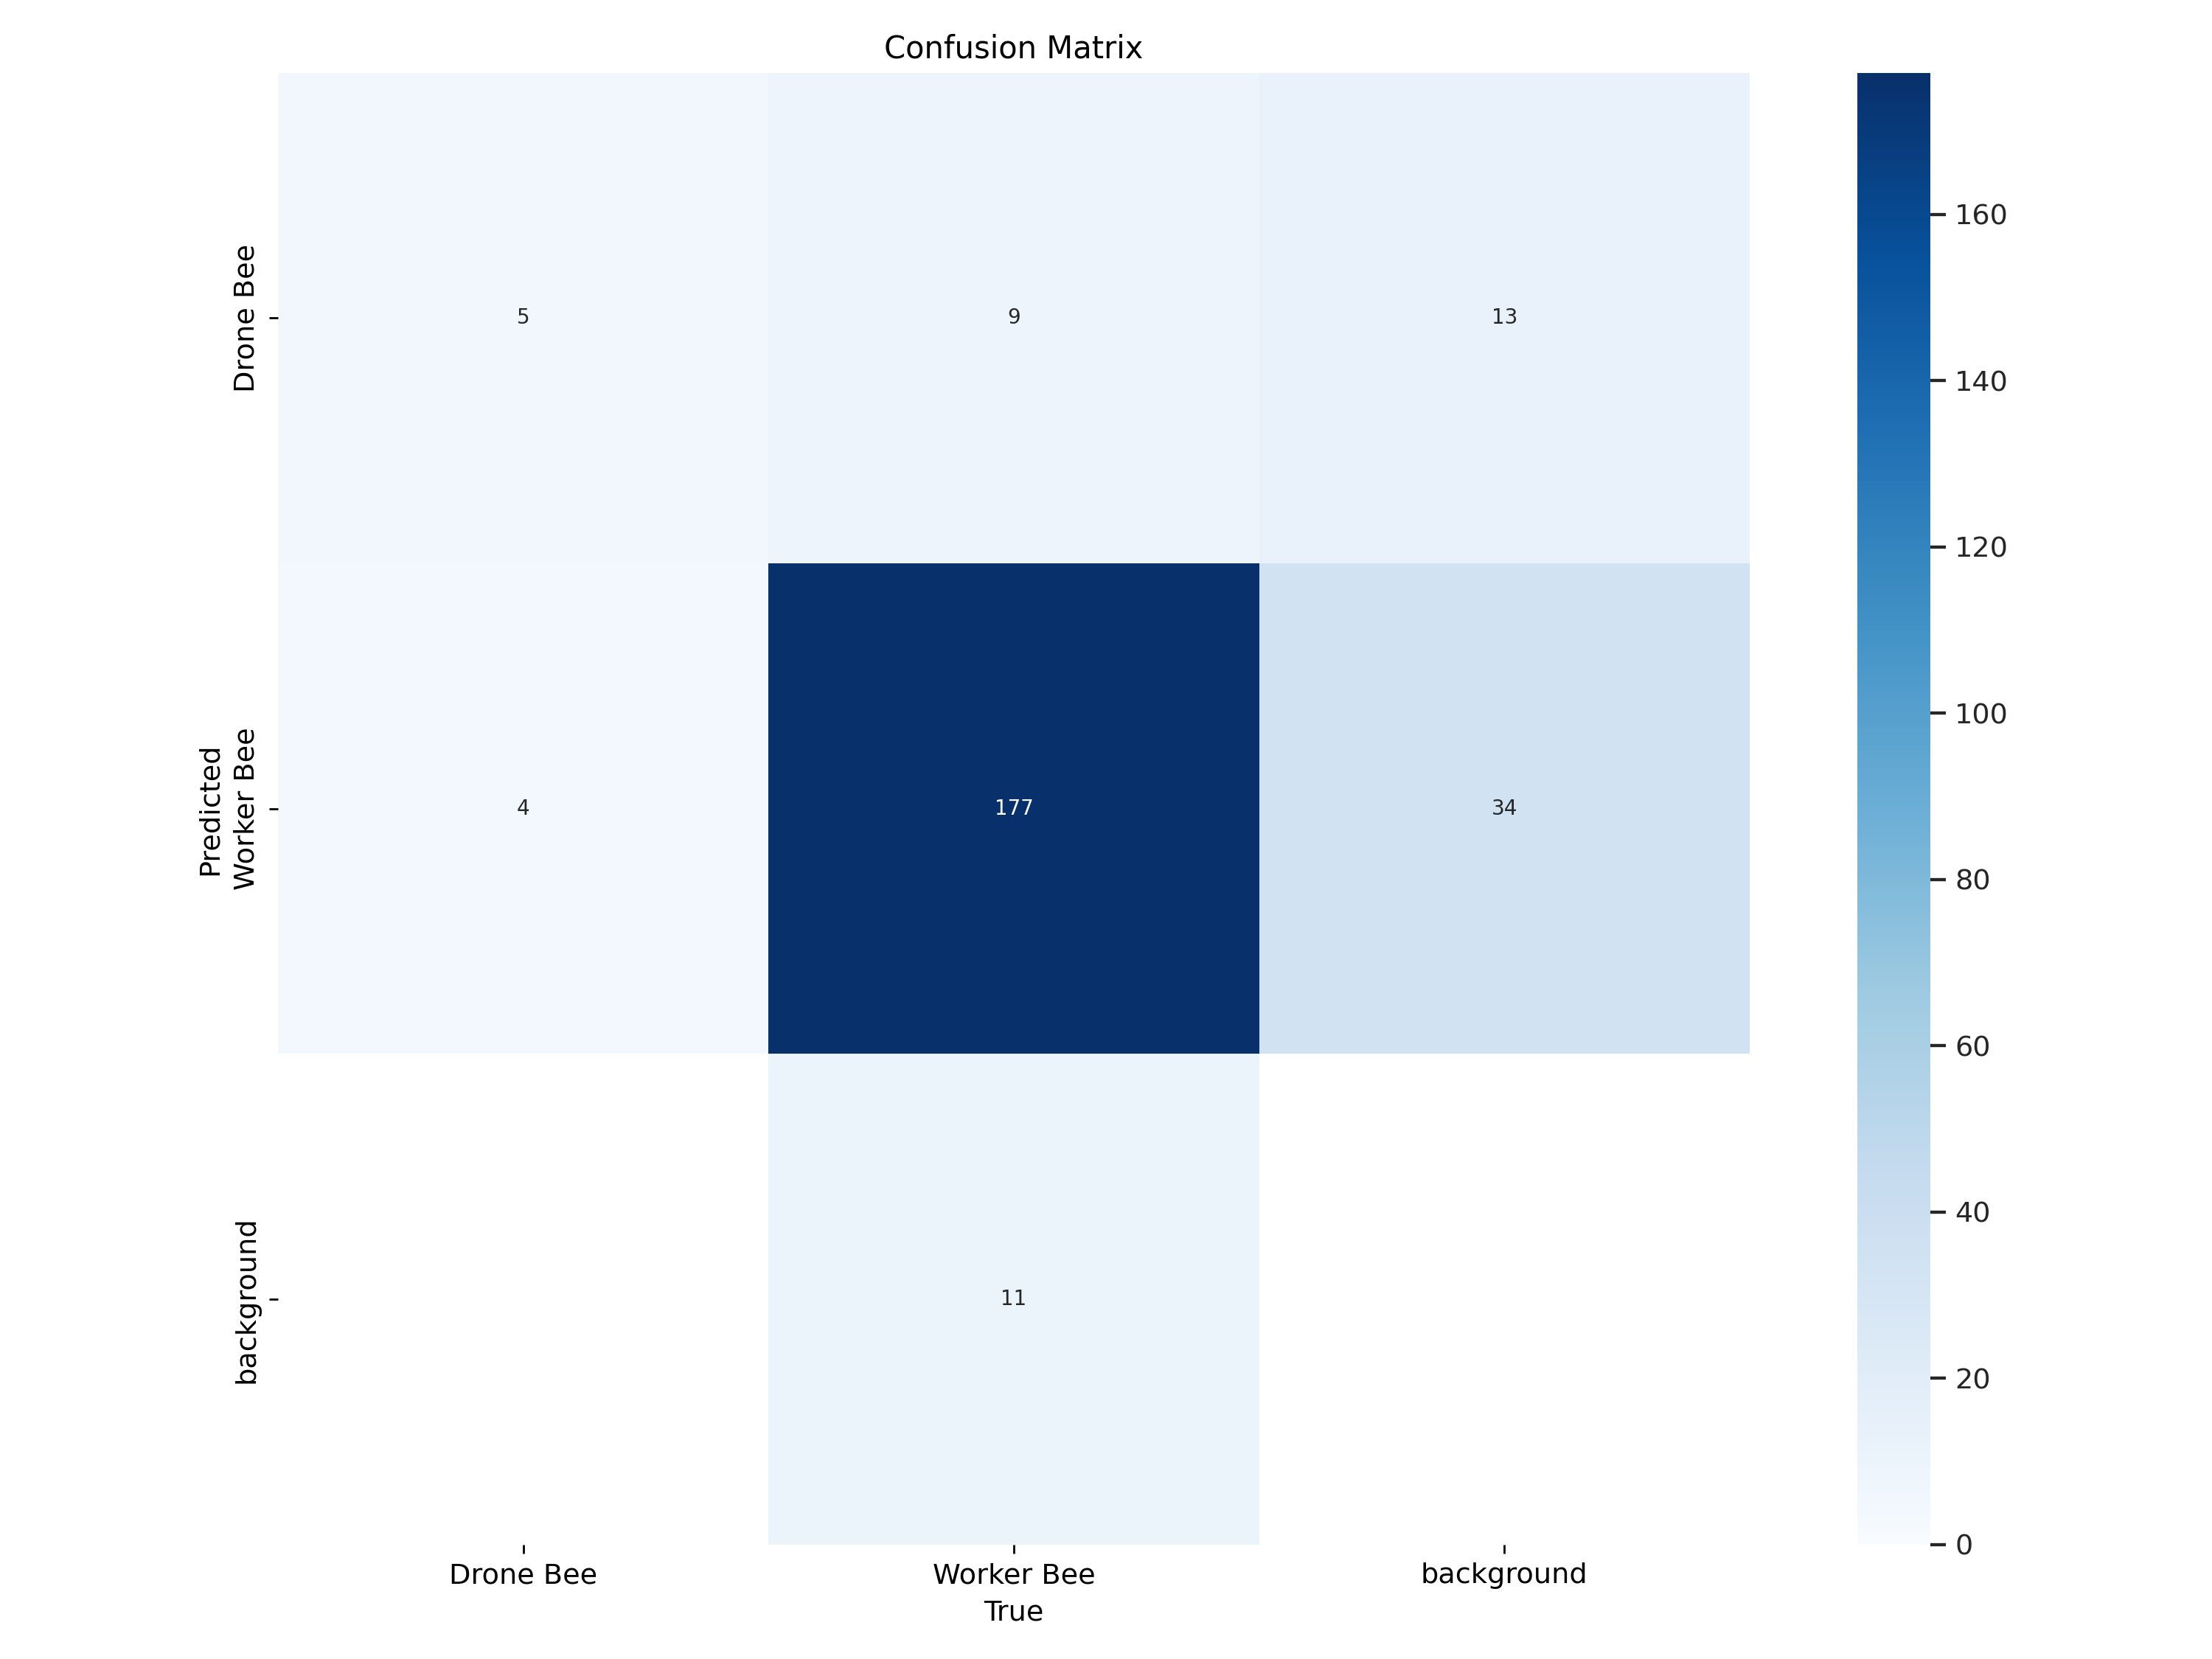

In [9]:
Image(filename=f'/content/yolo12_runs_version6/bee_imbalance/confusion_matrix.png', width=1000)

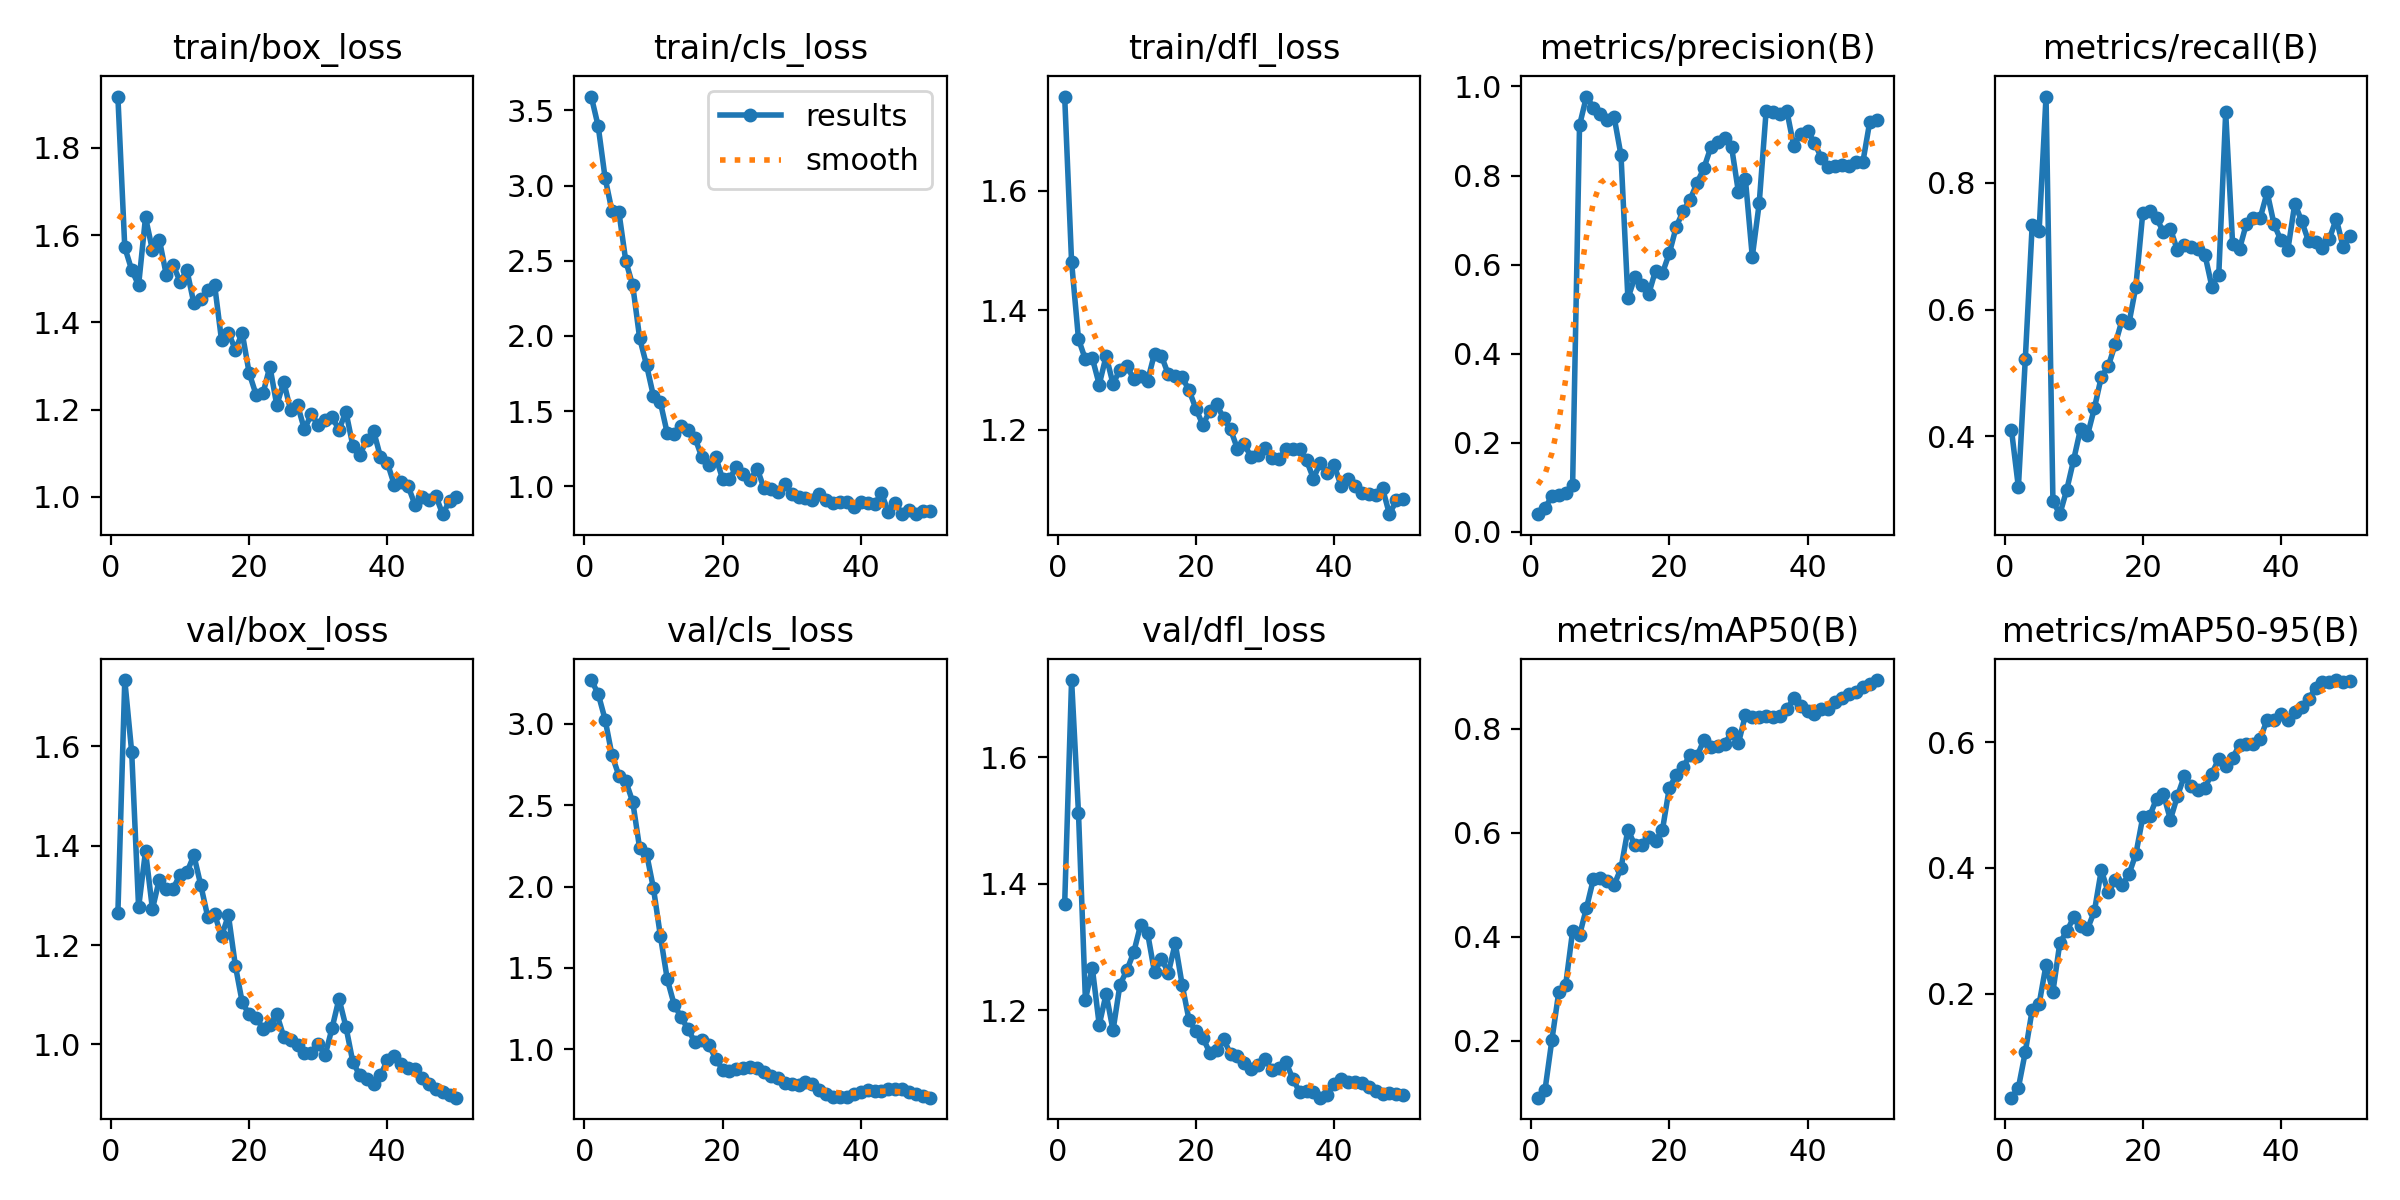

In [10]:
Image(filename=f'/content/yolo12_runs_version6/bee_imbalance/results.png', width=1000)


📊 confusion_matrix_normalized.png


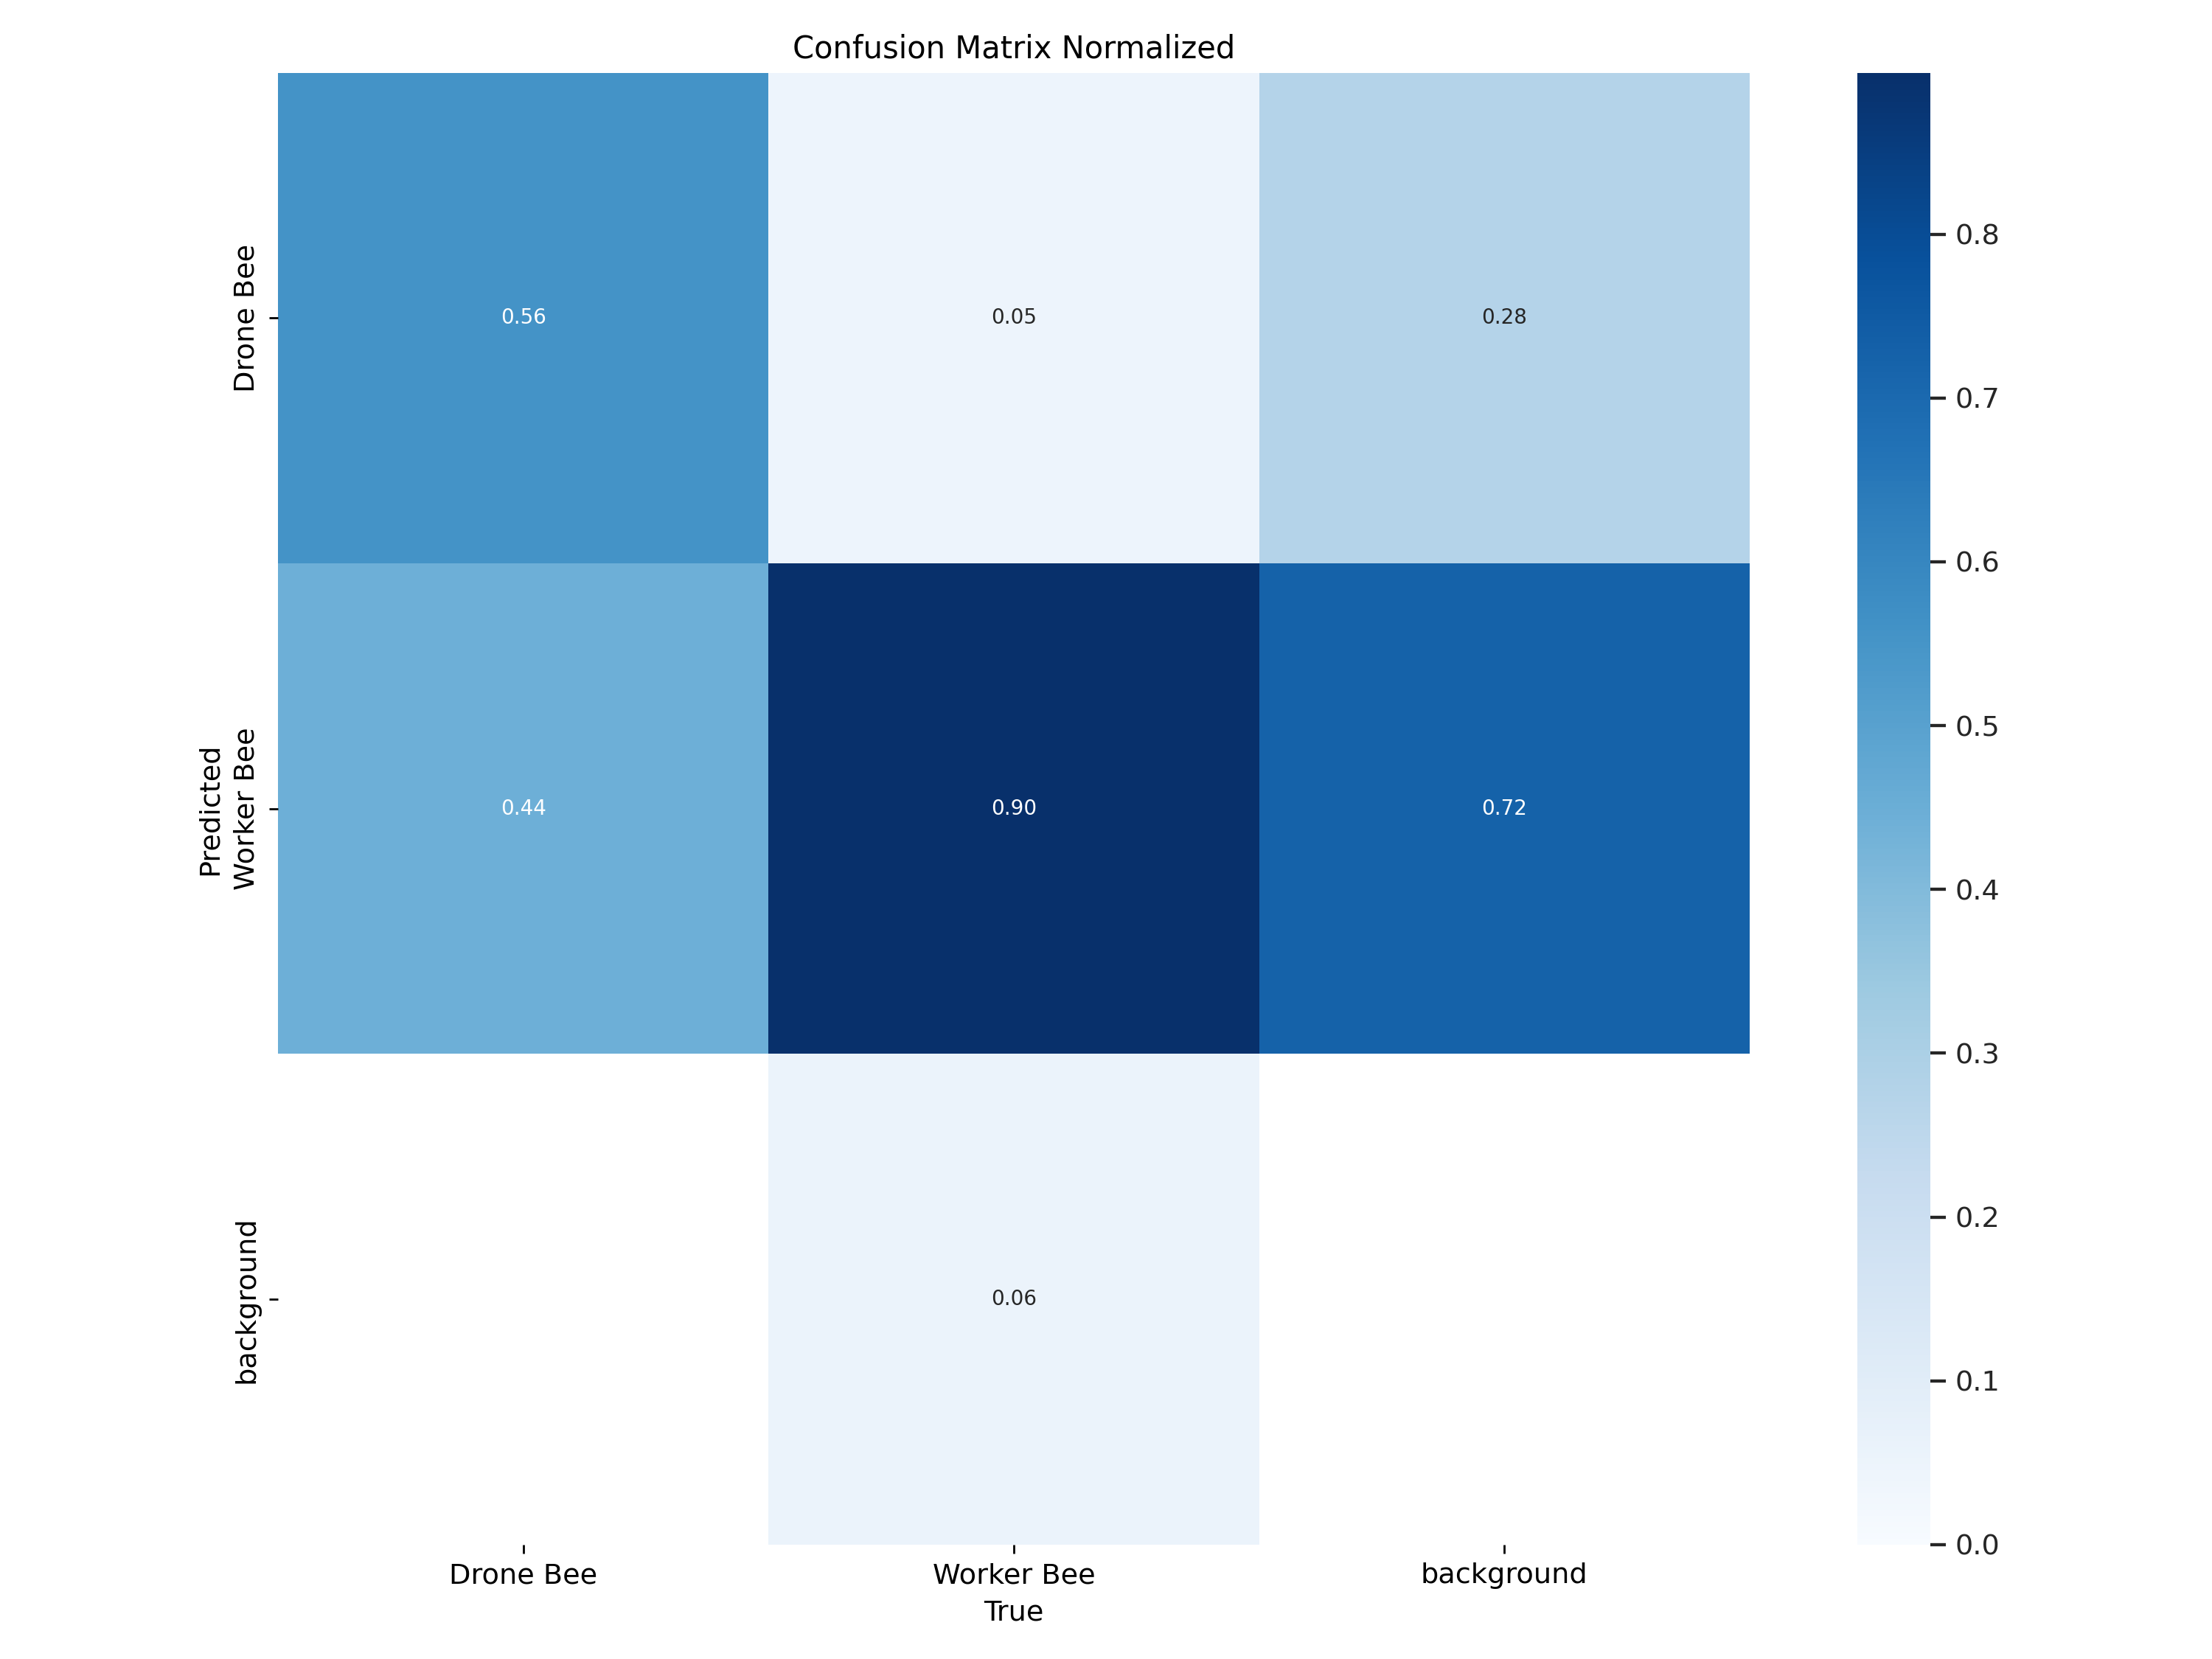


📊 BoxF1_curve.png
❌ BoxF1_curve.png not found

📊 BoxP_curve.png
❌ BoxP_curve.png not found

📊 BoxR_curve.png
❌ BoxR_curve.png not found

📊 BoxPR_curve.png
❌ BoxPR_curve.png not found

📊 labels.jpg


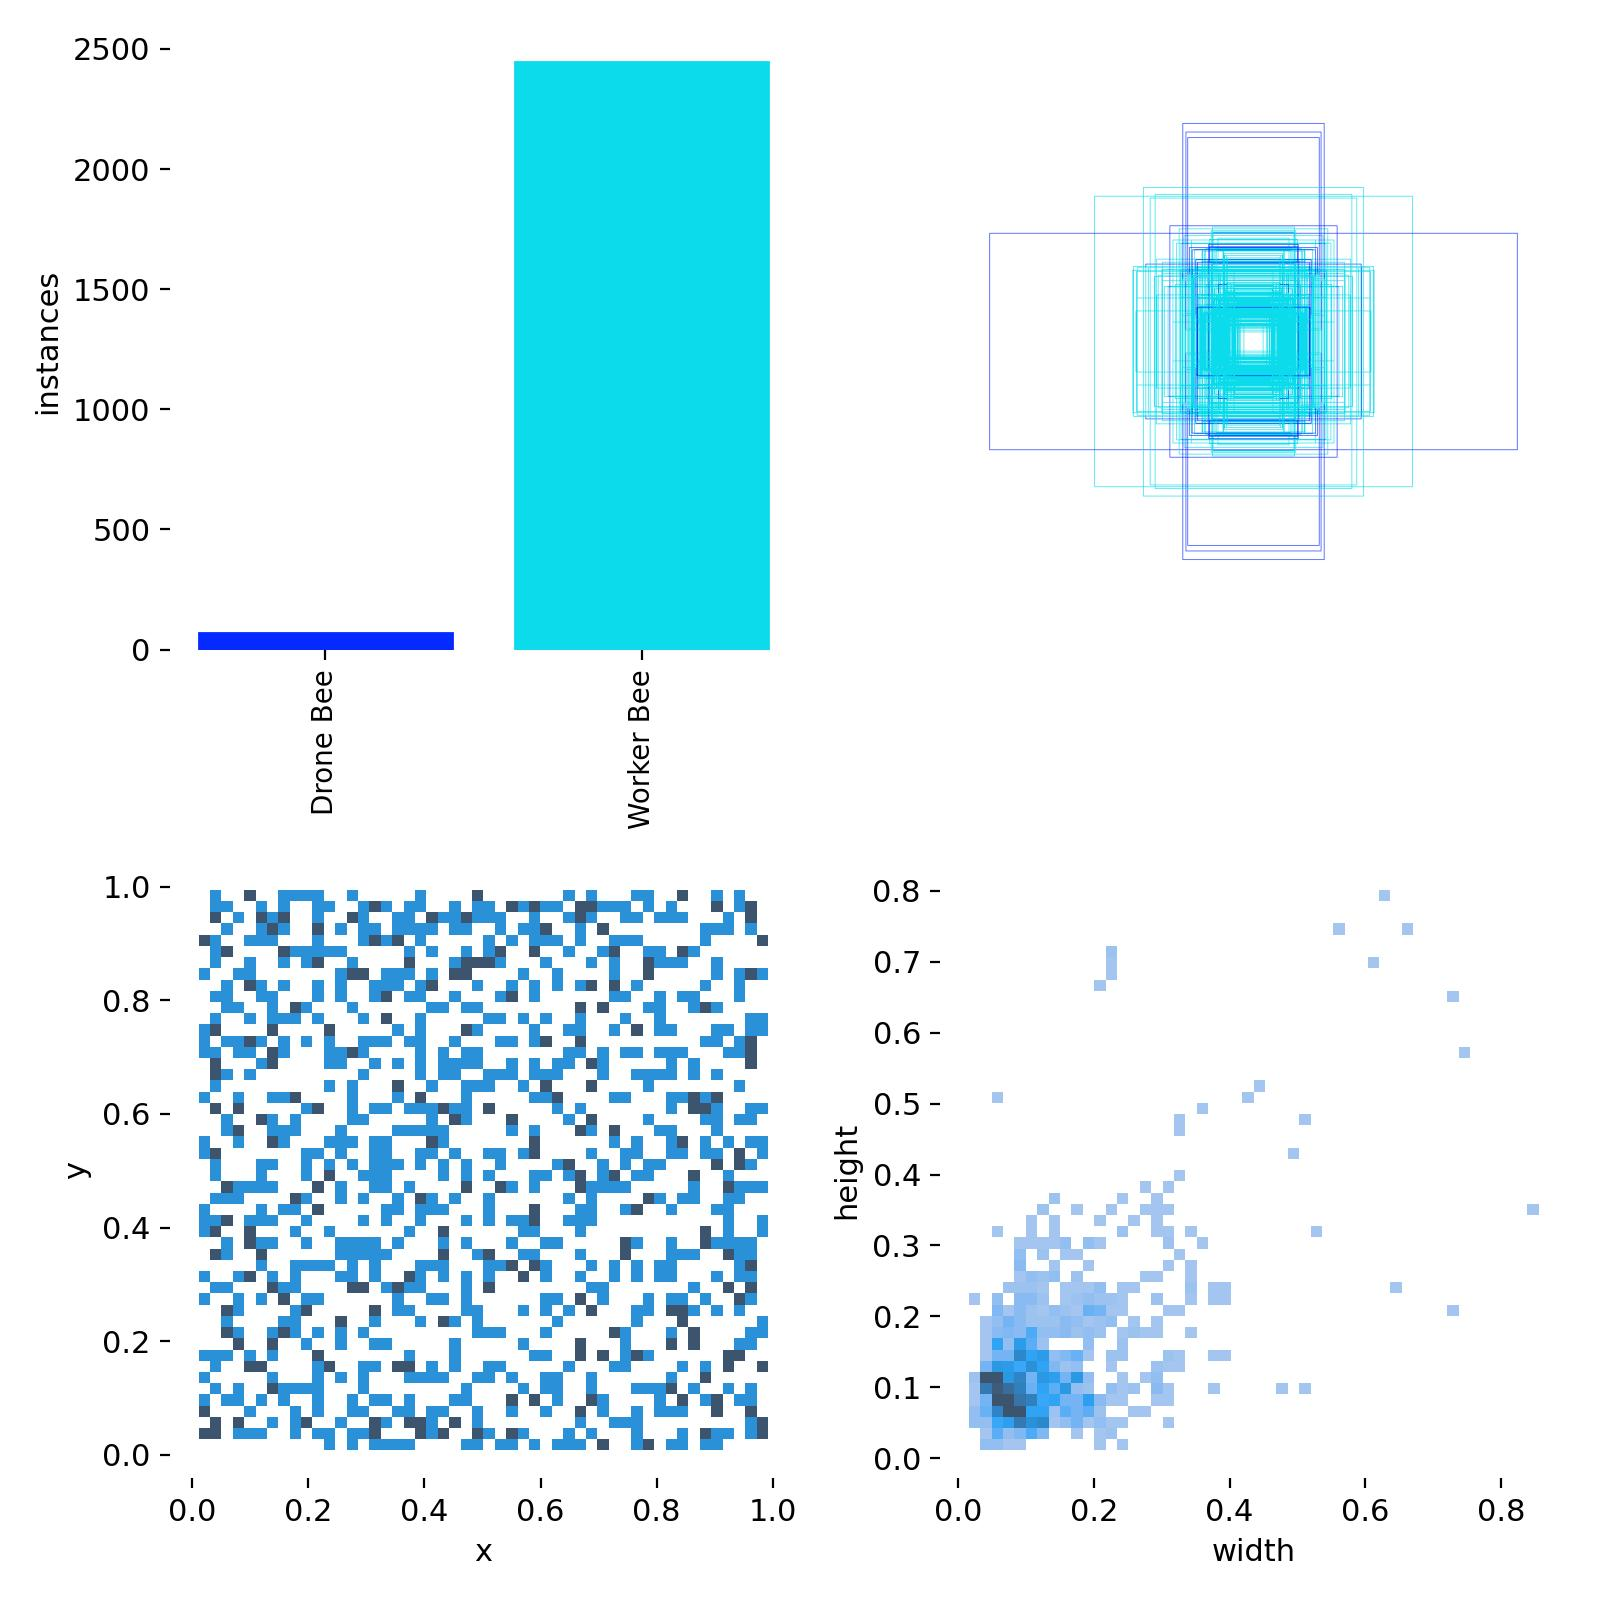

In [11]:
# Shows performance on the trainning images
training_images = [
    "confusion_matrix_normalized.png",
    "BoxF1_curve.png",
    "BoxP_curve.png",
    "BoxR_curve.png",
    "BoxPR_curve.png",
    "labels.jpg"
]


for img in training_images:
    path = f"/content/yolo12_runs_version6/bee_imbalance/{img}"
    try:
        print(f"\n📊 {img}")
        display(Image(filename=path, width=1000))
    except:
        print(f"❌ {img} not found")

In [12]:
ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Drone Bee', 'Worker Bee']

In [13]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/content/yolo12_runs_version6/bee_imbalance/weights/best.pt')
predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [14]:
# Evaluates on test set
results = model.val(
    data="/content/My-First-Project-6/data.yaml",
    split="test",
    plots=True,
    project="yolo_test_eval",
    name="bee_test_results"
)

print("✅ Evaluation complete!")

Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/My-First-Project-6/test/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 1880.69it/s]

val: New cache created: /content/My-First-Project-6/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


                   all          5        162      0.729      0.918      0.874      0.681
             Drone Bee          5          9       0.57          1      0.841      0.703
            Worker Bee          5        153      0.889      0.836      0.907       0.66
Speed: 0.3ms preprocess, 29.1ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to yolo_test_eval/bee_test_results
✅ Evaluation complete!


In [15]:
print(f"mAP50: {results.box.map50 : .2f}")
print(f"mAP50-95: {results.box.map: .2f}")
print(f"Precision: {results.box.mp: .2f}")
print(f"Recall: {results.box.mr: .2f}")

mAP50:  0.87
mAP50-95:  0.68
Precision:  0.73
Recall:  0.92


In [16]:
print(f"\nPer-Class mAP50:")
for i, class_name in enumerate(['Worker', 'Drone']):
    print(f"  {class_name}: {results.box.maps[i]:.3f}")

print(f"\nPer-Class Precision:")
for i, class_name in enumerate(['Worker', 'Drone']):
    print(f"  {class_name}: {results.box.class_result(i)[0]:.3f}")

print(f"\nPer-Class Recall:")
for i, class_name in enumerate(['Worker', 'Drone']):
    print(f"  {class_name}: {results.box.class_result(i)[1]:.3f}")


Per-Class mAP50:
  Worker: 0.703
  Drone: 0.660

Per-Class Precision:
  Worker: 0.570
  Drone: 0.889

Per-Class Recall:
  Worker: 1.000
  Drone: 0.836


In [17]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.6289001953216241
mAP 50 0.7987733855812533
mAP 75 0.7455953804789303


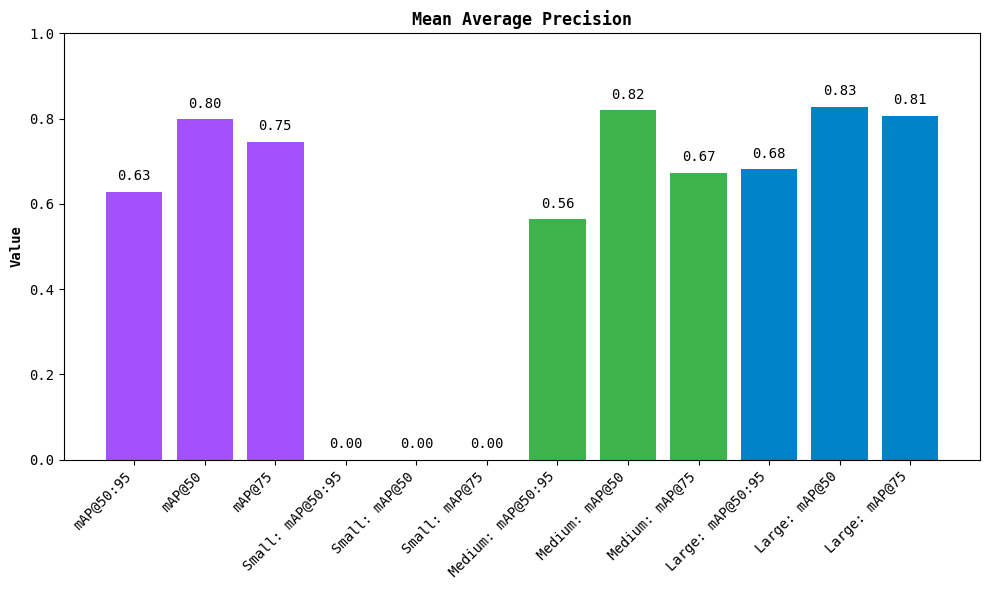

In [18]:
map.plot()

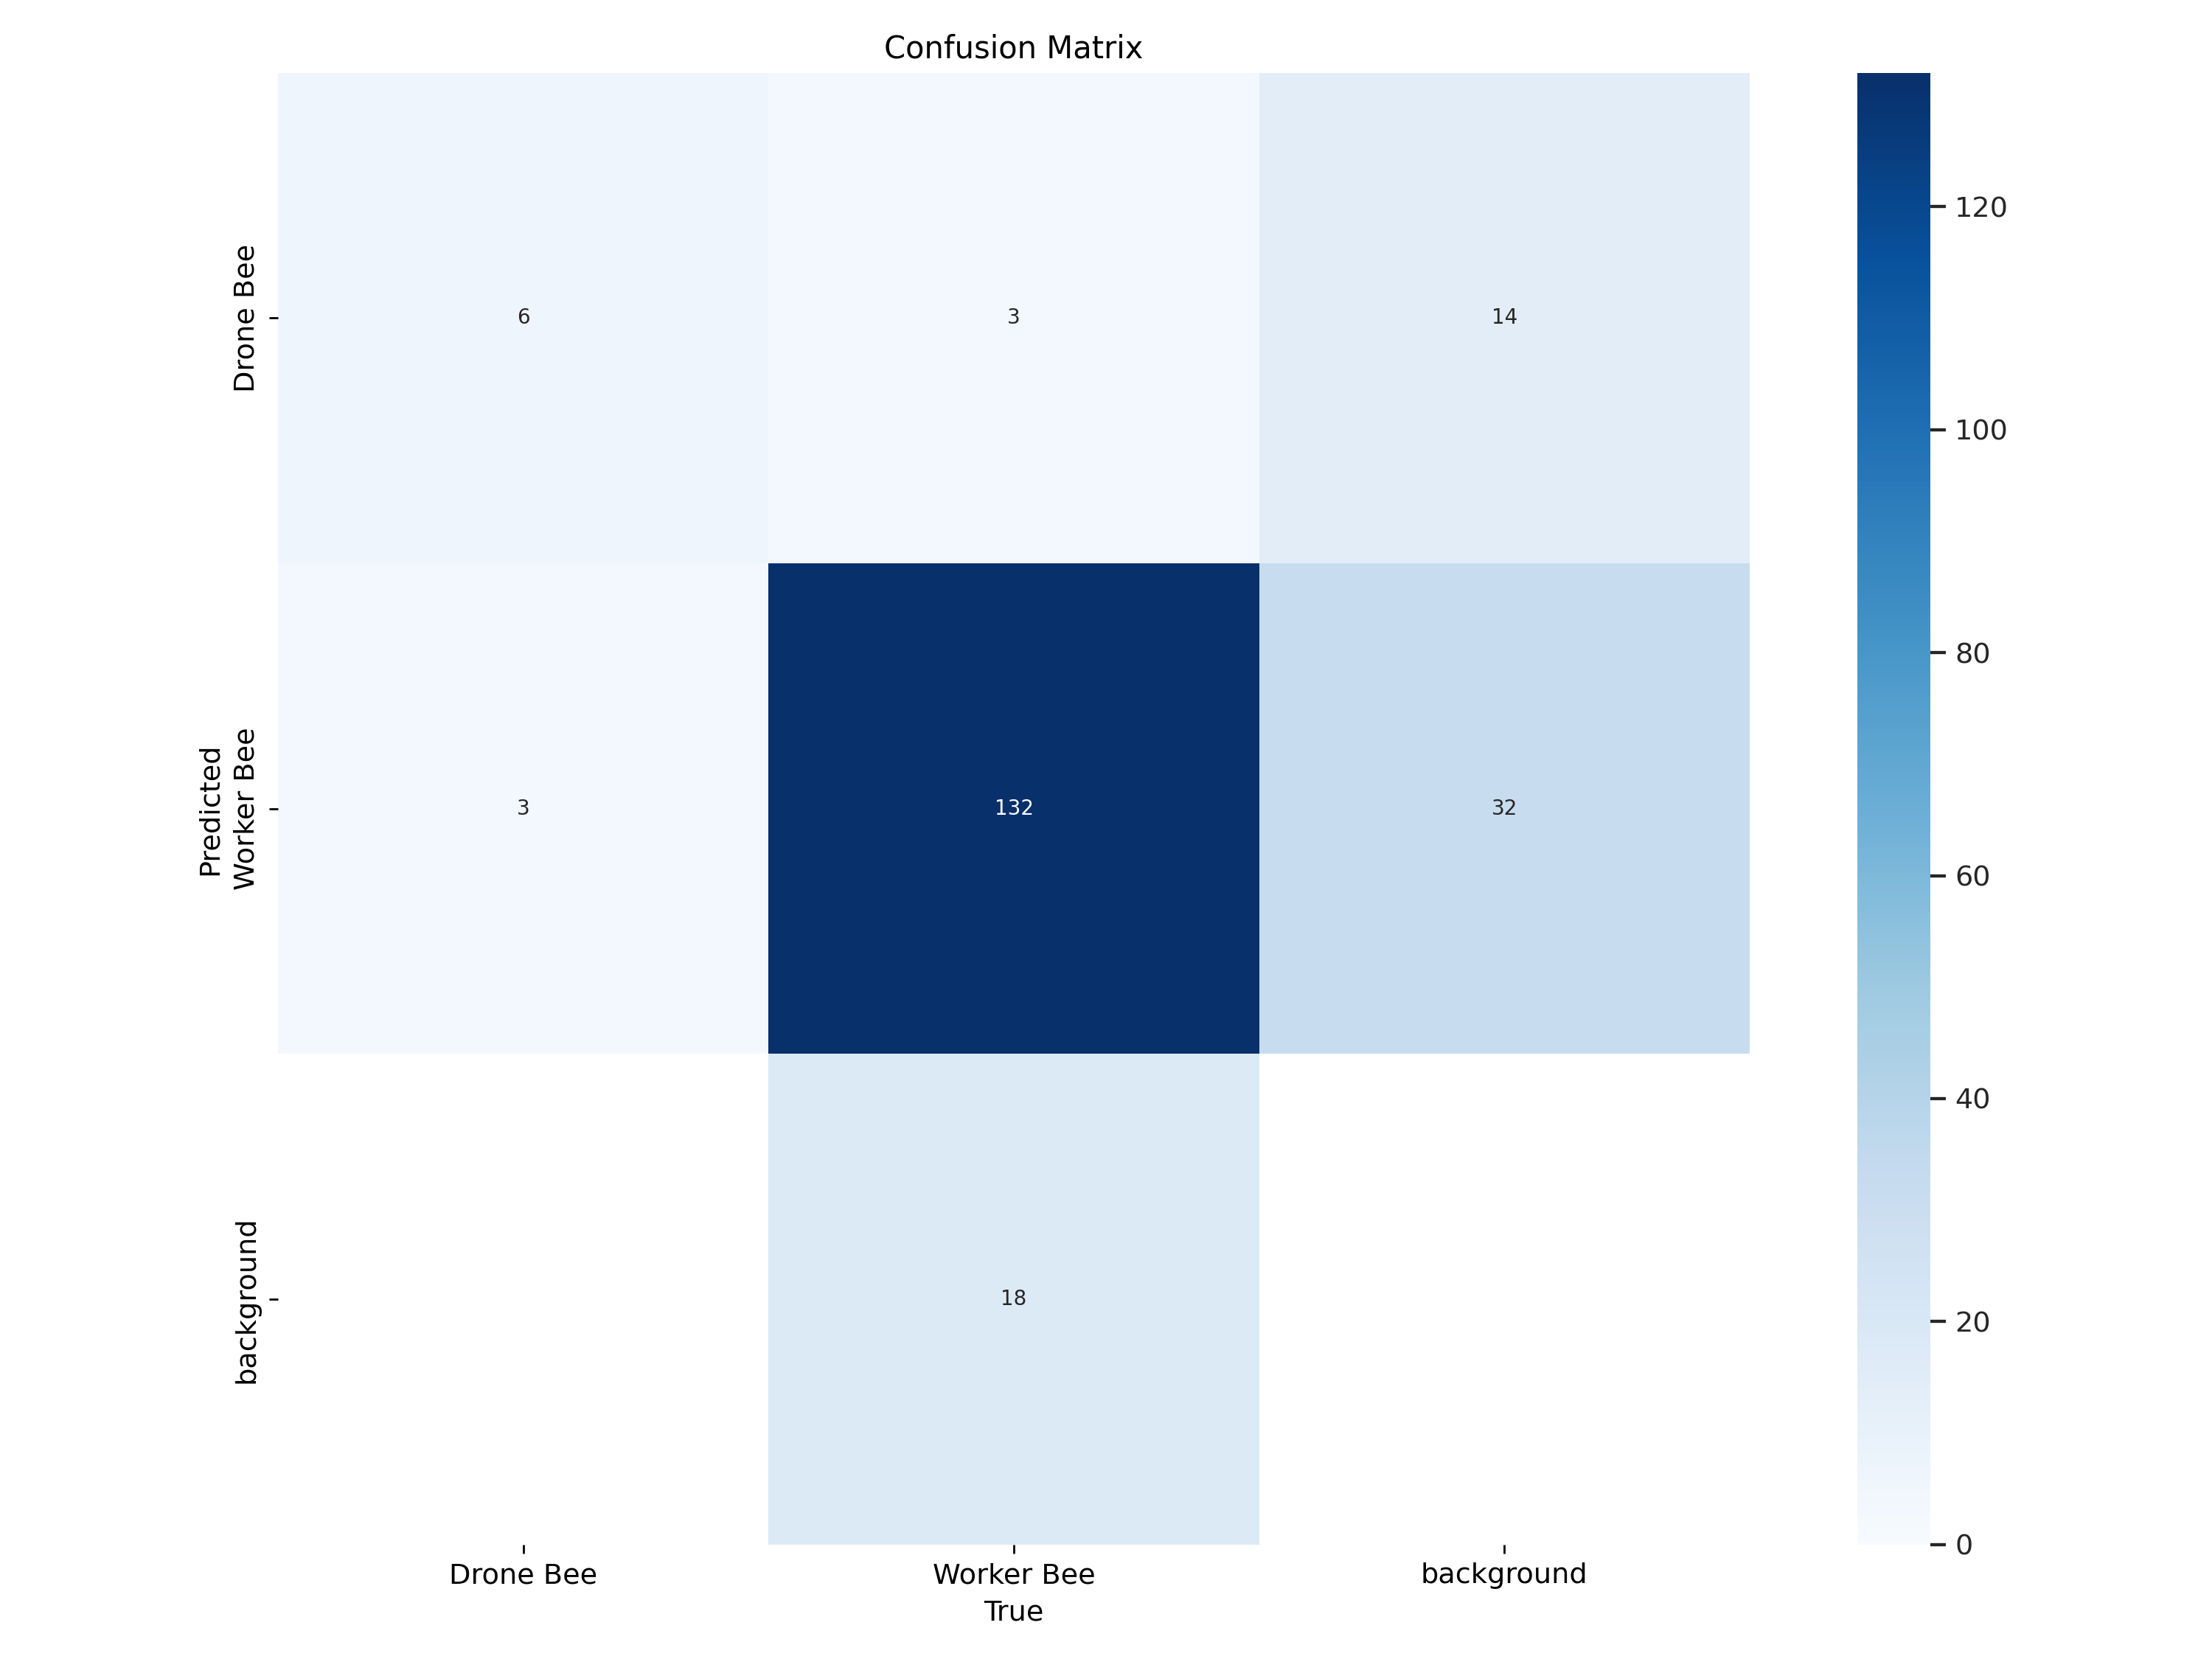

In [19]:
# Shows performance on the 5 test images
confmat_path_2 = "/content/yolo_test_eval/bee_test_results/confusion_matrix.png"
display(Image(filename=confmat_path_2))

In [20]:
# visualizes predictions on test images
model.predict(
    source=str(base / "test" / "images"),
    conf=0.25,
    project="/content/yolo12_runs_version6",
    name="bee_preds",
    save=True
)

Results saved to /content/yolo12_runs_version6/bee_preds


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Drone Bee', 1: 'Worker Bee'}
 obb: None
 orig_img: array([[[  0,  26,  34],
         [  0,  31,  40],
         [  0,  27,  42],
         ...,
         [  0,  15,  60],
         [  0,  14,  57],
         [  0,  17,  60]],
 
        [[159, 208, 218],
         [151, 201, 213],
         [136, 186, 204],
         ...,
         [133, 195, 241],
         [138, 203, 247],
         [144, 212, 255]],
 
        [[148, 217, 234],
         [135, 204, 223],
         [110, 184, 208],
         ...,
         [ 76, 182, 229],
         [ 85, 193, 240],
         [ 97, 205, 252]],
 
        ...,
 
        [[ 62, 108, 132],
         [ 65, 111, 135],
         [ 68, 113, 140],
         ...,
         [151, 165, 188],
         [134, 146, 170],
         [124, 136, 160]],
 
        [[ 92, 136, 159],
         [ 85, 129, 152],
         [ 64, 108, 132],
         ...

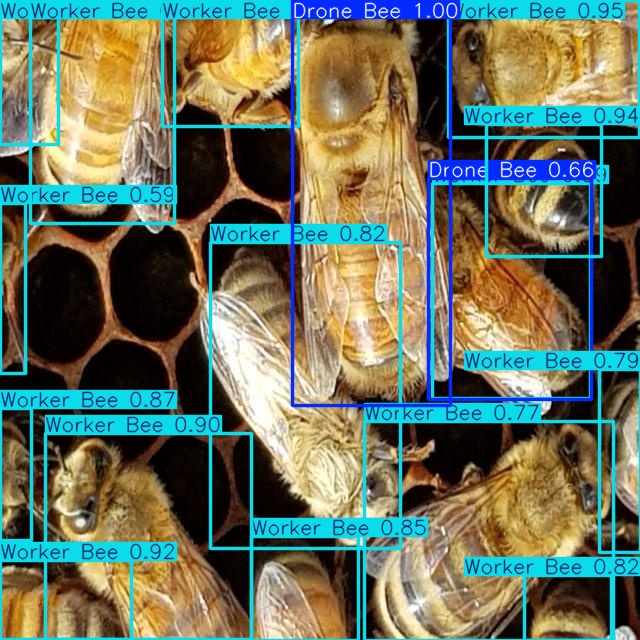

In [21]:
confmat_path_3 = "/content/yolo12_runs_version6/bee_preds/Worker-Bees_jpg.rf.de9c0bb317a8f58aff48c97b02827e34.jpg"
display(Image(filename=confmat_path_3))

## Run inference with fine-tuned YOLOv12 model

In [22]:
model = YOLO(f'/content/yolo12_runs_version6/bee_imbalance/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

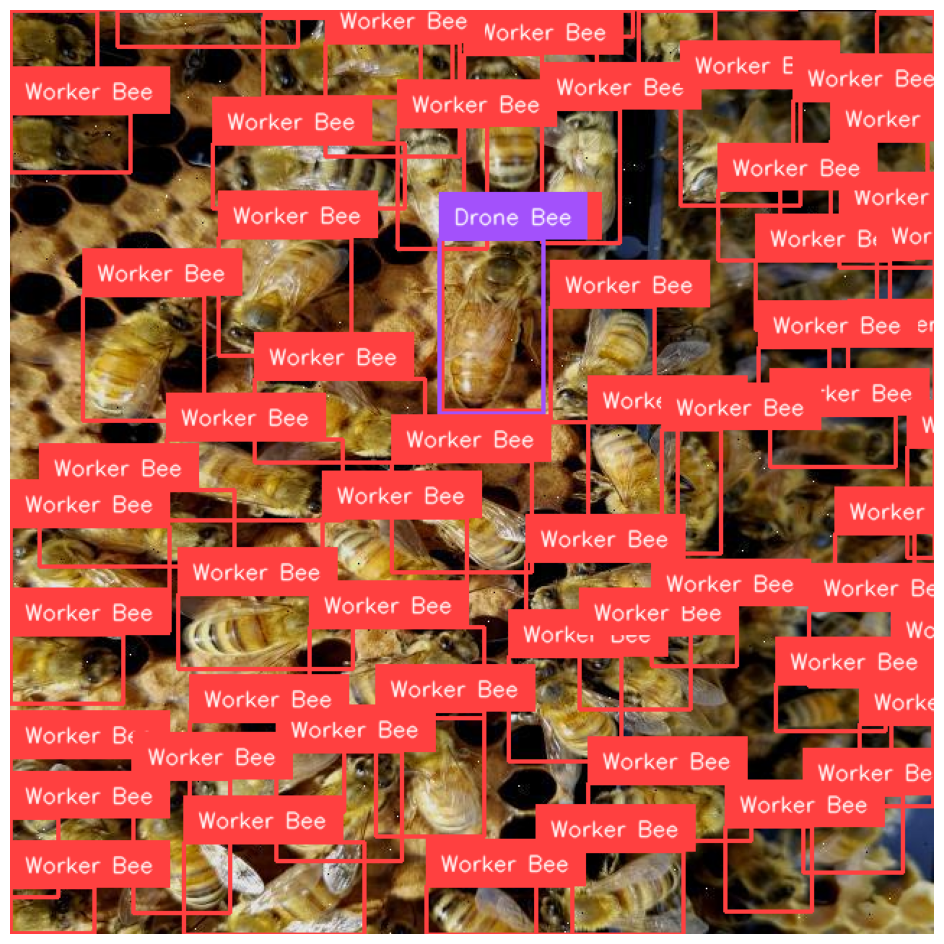

In [24]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)